In [1]:
# Gun Control 
# Demonstration that different ideas can be supported
# using small shifts in the data science process.
# Matt Spencer - DataBard
# www.databard.blog
# 3/29/2018
library(dplyr)
library(ggplot2)
library(tidyr)
library(purrr)
library(vcd)
library(fiftystater)
library(maps)
library(RColorBrewer)
library(grid)
library(gridExtra)
library(gtable)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'purrr'

The following objects are masked from 'package:dplyr':

    contains, order_by

Loading required package: grid

Attaching package: 'maps'

The following object is masked from 'package:purrr':

    map


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [7]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_line(colour="#f0f0f0"),
               #legend.key = element_rect(colour = NA),
               #legend.position = "bottom",
               #legend.direction = "horizontal",
               #legend.key.size= unit(0.2, "cm"),
               #legend.margin = unit(0, "cm"),
               #legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

# Function to generate the copyright for any plot
# Useage:
# g <- ggplot(...) + ...
# add.copyright(g)
# add.copyright(g, 0.5, 1/20)
add.copyright <- function(plot, fontsize=1, rel.height=1/20) {
       cp <- grid::textGrob(paste("\uA9 Matt Spencer ", format(Sys.time(), "%Y"), ", databard.blog", sep=''),
             gp=gpar(fontfamily = "Verdana", cex=fontsize) ,
             x=unit(1, "npc"), hjust = 1) #, y=unit(0, "npc"), vjust = 0)
    
    cp.h <- round(rel.height*100)
    plot.h <- 100-cp.h
    lay <- matrix(c(rep(1,plot.h), rep(2,cp.h)))
    
    return(gridExtra::grid.arrange(plot, cp, layout_matrix = lay))
}


In [3]:
# Generalized Functions
remove.paren <- function(df) {
    for (col in colnames(df)) {
        temp <- gsub("\\(\\S*\\)", "", df[,col])
        df[,col] <- gsub("\\[\\S*\\]", "", temp)
    }
    return(df)
}
remove.commas <- function(df, cols) {
    for (col in cols) df[,col] <- as.numeric(gsub(",", "", df[,col]))
    return(df)
}
infer.population <- function(name, years, data, newyears) {
    exponential.model <- lm(log(data) ~ years)
    return(data.frame(State = name, Year = newyears, 
                      Pop = exp(predict(exponential.model, list(years = newyears))),
                      stringsAsFactors = F))
}

# These functions may be useful in the future
# They were used to spread out the labels iteratively
# until they were no longer overlapping.
next.group.min.max <- function(df, col, max.diff = 1) {
    df <- df %>% 
        mutate(id = row_number()) %>%
        arrange_(col)
    
    ids <- c()
    for (i in 2:(nrow(df))) {
        if (df[i, col] < df[i - 1, col] + max.diff) {
            ids <- c(ids, df[i - 1, "id"], df[i, "id"])
        }
        else if (length(ids) > 0) break 
    }
    if (length(ids) == 0) return(c())
    return(c(ids[1], ids[length(ids)]))
}
        
spread.pair <- function(df, col, ids, interval = 0.1, min = 0.5) {
    df[ids[1], col] <- df[ids[1], col] - interval
    df[ids[2], col] <- df[ids[2], col] + interval
    if(df[ids[1], col] < min) {
        correction <- min - df[ids[1], col]
        df[ids[1], col] <- df[ids[1], col] + correction
        df[ids[2], col] <- df[ids[2], col] + correction
    }
    return(df)
}

spread.all.labels <- function(df, col) {
    while (TRUE) {
        min.max <- next.group.min.max(df, col)
        if (length(min.max) == 0) break
        df <- spread.pair(df, col, min.max)
    }
    return(df)
}

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, ymin, ymax"Warning message:
"Ignoring unknown aesthetics: xmin, xmax, ymin, ymax"

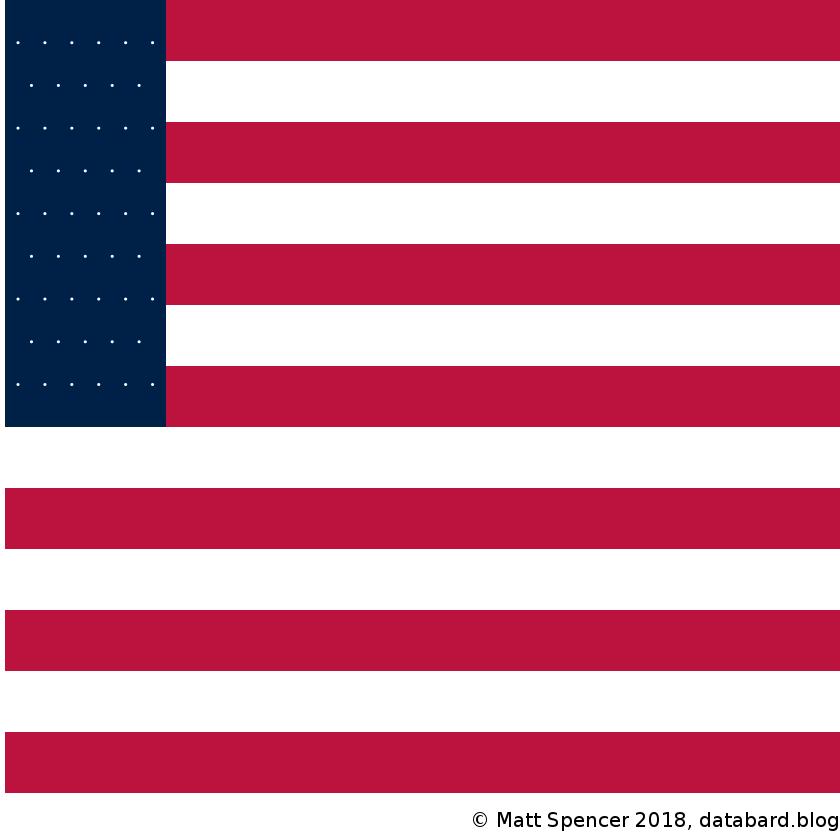

In [5]:
# Plot the USA flag
us.flag <- function(width, height, starsize = 1) {
    usblue <- rgb(0, 33, 71, max = 255)
    usred <- rgb(187, 19, 62, max = 255)
    
    square.bot <- height * 6/13
    square.edge <- min(width * 0.4, height * 1.5)
    
    square <- data.frame(xmin = 0, xmax = square.edge, ymin = square.bot, ymax = height)
    stripes <- data.frame(xmin = c(rep(0, 3), rep(square.edge, 4)), xmax = width,
                          ymin = seq(0, 12, 2) * (height * 1/13), ymax = seq(1, 13, 2) * (height * 1/13))
    
    h.int <- (height - square.bot) / 10
    sh <- square.bot + (1:9 * h.int)

    w.int <- square.edge / 12
    sw <- 1:11 * w.int
    stars <- expand.grid(sh, sw) %>% mutate(rank1 = group_indices(., Var1), rank2 = group_indices(., Var2)) %>%
        filter((rank1 + rank2) %% 2 == 0) %>%
        rename(x = Var2, y = Var1) %>%
        select(x, y)
    
    us.flag <- ggplot(square, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax)) +
        geom_rect(fill = usblue) +
        geom_rect(data = stripes, fill = usred) +
        geom_point(data = stars, aes(x = x, y = y, xmin = NULL, xmax = NULL, ymin = NULL, ymax = NULL), 
                   color = "white", size = starsize) +
        scale_x_continuous(limits = c(0, width), expand = c(0, 0)) +
        scale_y_continuous(limits = c(0, height), expand = c(0, 0)) +
        theme_void()
    return(us.flag)
}

flag.small <- us.flag(1.35, 1.85, 0.1)
flag.long <- us.flag(6.52, 0.84, 0.2)
add.copyright(flag.long)
#ggsave(file = '../Figures/us.flag.small.tiff', flag.small, width = 1.35, height = 1.85, dpi = 300)
#ggsave(file = '../Figures/us.flag.long.tiff', flag.long, width = 6.52, height = 0.84, dpi = 300)

In [5]:
# Viz 1 Data Loading and Prep

# Load First World Countries list ("Fully Developed" Countries)
# https://en.wikipedia.org/wiki/The_World_Factbook_list_of_developed_countries
fully_developed <- scan("data/DevelopedCountries.txt", what = character(), sep = "\n")

# Load and prep murder_rates table
# https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate
murder_rates <- read.csv("data/wiki_homicides.csv", stringsAsFactors = F) %>% filter(!is.na(Rate))
colnames(murder_rates) <- c("Country", "Rate", "Count", "Region", "Subregion", "Year", "Notes")
murder_rates <- murder_rates %>% select(-Year, -Notes)

# Load and prep gun_murders table
# https://en.wikipedia.org/wiki/List_of_countries_by_firearm-related_death_rate
gun_murders <- read.csv("data/wiki_firearm_deaths.csv", stringsAsFactors = F)
gun_murders <- suppressWarnings(
    gun_murders %>% 
    remove.paren() %>%
    mutate(Year = as.numeric(Year), Homicides = as.numeric(Homicides), Suicides = as.numeric(Suicides),
           Unintentional = as.numeric(Unintentional), Undetermined = as.numeric(Undetermined),
           Guns.per.100 = as.numeric(Guns.per.100.inhabitants)) %>%
    select(-Year, -Sources.and.notes, -Total, -Guns.per.100.inhabitants) %>%
    na.omit()
    )

# Merge to form final data set
v1.data <- merge(murder_rates, gun_murders, by = "Country") %>% 
    select(-Count) %>%
    rename(All.murder.rate = Rate) %>%
    arrange(-Homicides) %>%
    mutate(Non.gun.murder = All.murder.rate - Homicides, Hom.Rank = row_number()) %>%
    filter(Hom.Rank < 11 | Country == "United States") 
v1.data$Country <- factor(v1.data$Country, levels = rev(v1.data$Country))

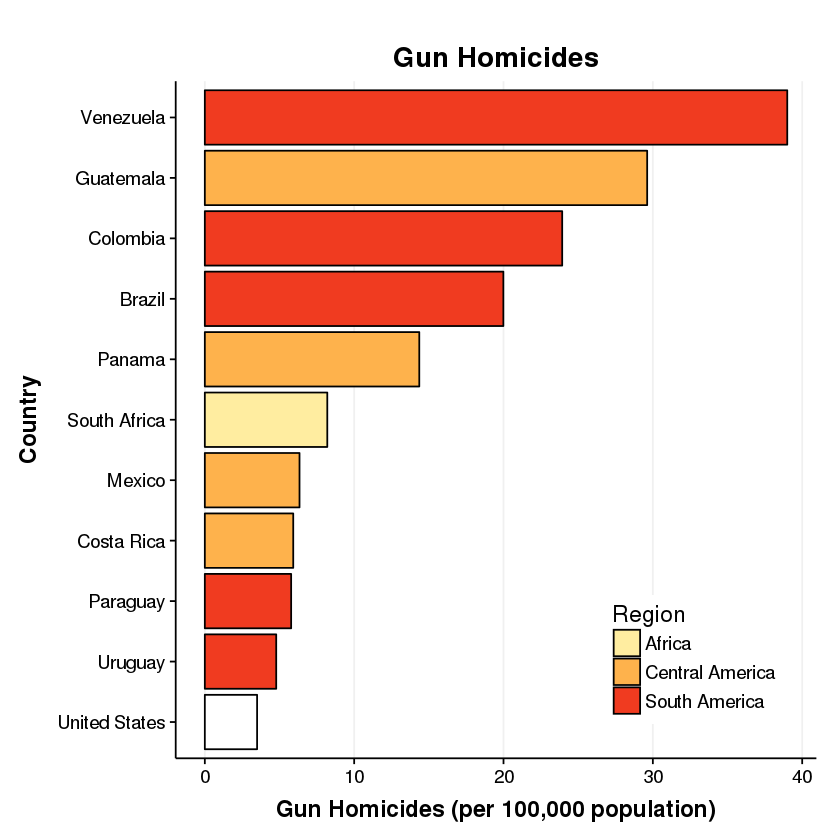

In [6]:
# Viz 1
# Compare murder rates for various countries and gun-specific murder rates for those countries 
# (cross reference with number of guns per capita)
v1.1.colors <- c("#feb24c", "#ffffff", "#f03b20", "#ffeda0")
v1.gun_homicides <- v1.data %>%
    ggplot(aes(y = Homicides, x = Country, fill = Subregion)) +
        geom_col(color = "black") +
        coord_flip() +
        ggtitle("Gun Homicides") +
        labs(y = "Gun Homicides (per 100,000 population)") +
        scale_fill_manual(breaks = c("Southern Africa", "Central America", "South America"), 
                          labels = c("Africa", "Central America", "South America"),
                          values = v1.1.colors) +
        guides(fill = guide_legend(title = "Region")) +
        theme_Publication() +
        theme(
            #text = element_blank(),
            
            panel.grid.minor = element_blank(),
            panel.grid.major.y = element_blank(),
            legend.key = element_blank(),
            legend.justification = c(1, 0), 
            legend.position = c(0.95, 0.05)
        ) 
v1.gun_homicides
#ggsave(file = 'figures/1.gun_homicides.tiff', v1.gun_homicides, width = 5, height = 6, dpi = 300)

In [6]:
# Viz 1 (part 2)
# Compare murder rates for various countries and gun-specific murder rates for those countries 
# (cross reference with number of guns per capita)
v1.2.data <- merge(murder_rates, gun_murders, by = "Country") %>% 
    select(-Count) %>%
    rename(All.murder.rate = Rate) %>%
    filter(Country %in% fully_developed) %>%
    arrange(-Homicides) %>%
    mutate(Non.gun.murder = All.murder.rate - Homicides, Hom.Rank = row_number()) %>%
    filter(Hom.Rank < 11 | Country == "United States") 
v1.2.data$Country <- factor(v1.2.data$Country, levels = rev(v1.2.data$Country))
v1.2.data$Subregion <- factor(v1.2.data$Subregion, levels = c("Western Asia", "Northern Europe", 
                                                              "Southern Europe", "Western Europe", "Northern America"))

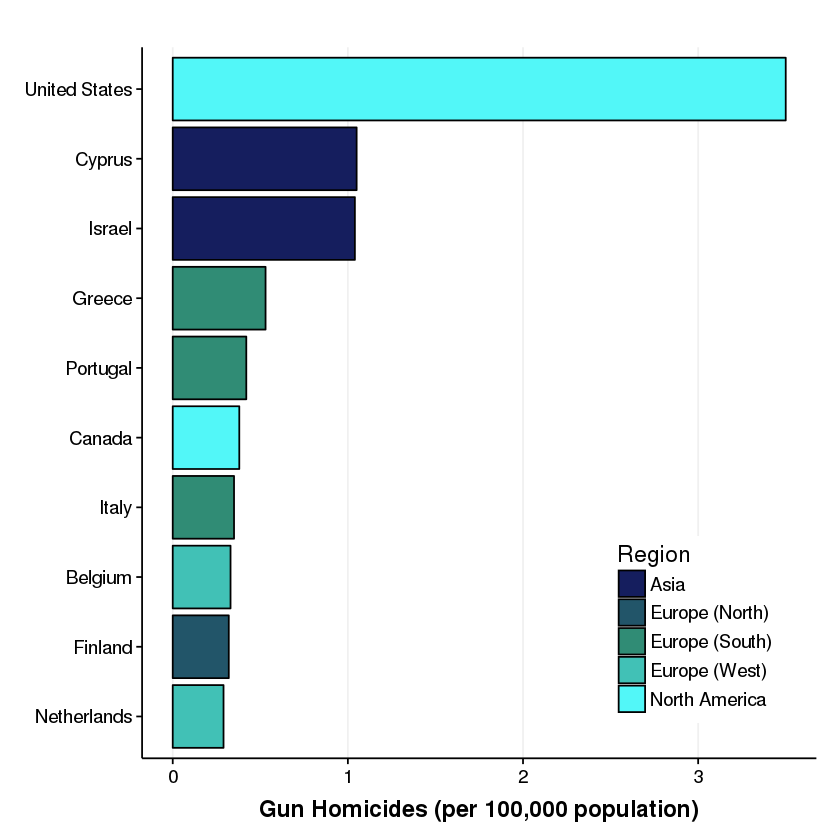

In [7]:
colfunc <- colorRampPalette(c("#151E5E", "#308C75", "#52F7F8"))
v1.gun_homicides_developed <- v1.2.data %>%
    ggplot(aes(y = Homicides, x = Country, fill = Subregion)) +
        geom_col(color = "black") +
        coord_flip() +
        #ggtitle("Gun Homicides\nDeveloped Countries") +
        labs(y = "Gun Homicides (per 100,000 population)") +
        scale_fill_manual(labels = c("Asia", "Europe (North)", "Europe (South)", "Europe (West)", "North America"),
                          values = colfunc(5)) +
        guides(fill = guide_legend(title = "Region")) +
        theme_Publication() +
        theme(
            #text = element_blank(),
            panel.grid.minor = element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.y = element_blank(),
            
            legend.justification = c(1, 0), 
            legend.position = c(0.95, 0.05),
            legend.key = element_blank()
        )
v1.gun_homicides_developed
#ggsave(file = 'figures/1.gun_homicides_developed.tiff', v1.gun_homicides_developed, width = 5, height = 6, dpi = 300)

In [8]:
# Viz 2 Data Loading and Prep

# Load and prep us_murders table
# https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate
us_murders <- read.csv("data/wiki_homicides_us_by_year.csv", stringsAsFactors = F) %>% select(-Sources) %>% 
    rename(State = United.States)

us_murders_yearly <- us_murders %>% 
    gather(key=Year, value=MurdersPer100000, paste("X", 2000:2012, sep='')) 
us_murders_yearly$Year <- gsub('X', '', us_murders_yearly$Year)

# Load and prep state_pops_yearly table
# https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population
state_pops <- read.csv("data/wiki_state_populations.csv", stringsAsFactors = F) %>%
    remove.commas(2:7)
state_pops_yearly <- data.frame(State = character(), Year = numeric(), Pop = numeric(), stringsAsFactors = F)
 
for (i in 1:nrow(state_pops)) {
    state_pops_yearly <- rbind(state_pops_yearly, 
                               infer.population(state_pops$Name[i], 
                                                seq(1960, 2010, 10), 
                                                as.numeric(state_pops[i, 2:7]), 
                                                2000:2012)
                              )
}

# Load Brady State Scores
# http://www.crimadvisor.com/data/Brady-State-Scorecard-2014.pdf
brady_scores <- read.csv("data/brady_state_scores.csv", stringsAsFactors = F, header = F)
colnames(brady_scores) <- c("State", "BradyScore")

# Load State Suicide Rates
# https://en.wikipedia.org/wiki/Suicide_in_the_United_States
state_suicides <- read.csv("data/wiki_state_suicides.csv", stringsAsFactors = F) %>%
    mutate(share = Suicide.rate.per.100000.people / sum(Suicide.rate.per.100000.people)) %>%
    select(State, share)

# Load US Suicides by year
yearly_suicides <- read.csv("data/yearly_suicide_rate.csv", stringsAsFactors = F)

# Join and extrapolate
suicides_state_year <- merge(state_suicides, yearly_suicides) %>% 
    mutate(SuicideRatePer100000 = RatePer100000 * 50 * share) %>%
    select(-RatePer100000, -share) 

# Viz 2 data
v2.data <- merge(us_murders_yearly, suicides_state_year) %>%
    mutate(GunDeathsPer100000 = MurdersPer100000 + SuicideRatePer100000) %>%
    merge(brady_scores) %>%
    mutate(brady = ifelse(BradyScore > 0, "Most Restrictive", "Least Restrictive"), Year = as.numeric(Year))

# Specific prep for Viz 2
select.states <- c(brady_scores$State[1:5], brady_scores$State[46:50])

v2.labels <- v2.data %>%
    filter(State %in% select.states, Year == 2012) %>%
    mutate(death.label.y = GunDeathsPer100000, murder.label.y = MurdersPer100000)
v2.labels <- spread.all.labels(v2.labels, "death.label.y")
v2.labels <- spread.all.labels(v2.labels, "murder.label.y")

brady.green   <- rgb(  0, 158,  13, max = 255)
brady.red     <- rgb(209,   0,   0, max = 255)
brady.green.l <- rgb( 51, 255,  68, max = 255)
brady.red.l   <- rgb(255, 102, 102, max = 255)

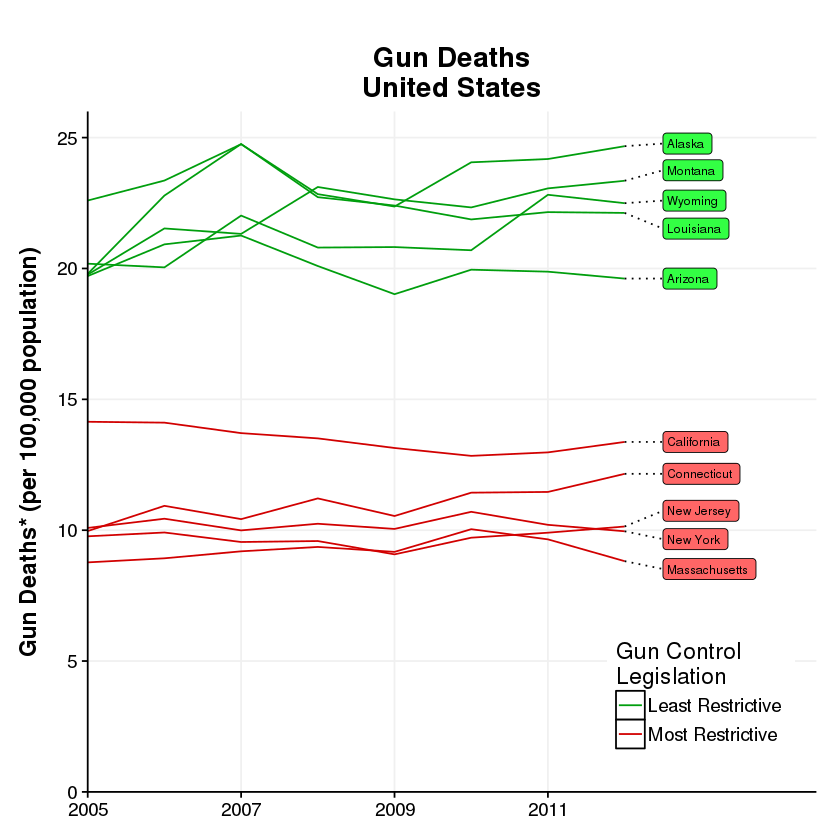

In [9]:
# Viz 2 part 1
label.align <- 2012.5
v2.deaths_by_state <- v2.data %>% 
    filter( State %in% select.states ) %>%
    filter( Year >= 2005 ) %>%
    ggplot(aes(x = Year, y = GunDeathsPer100000, color = brady, group = State)) +
    geom_line() +
    geom_label(data = v2.labels, 
               aes(x = label.align, y = death.label.y, label = State, fill = brady), color = "black", size = 2.5, hjust = 0) +
    geom_segment(aes(x = 2012, y = GunDeathsPer100000, xend = label.align, yend = death.label.y), 
                 color = "black", linetype = 3, data = v2.labels) +
    scale_y_continuous(limits = c(0, 26), expand = c(0, 0)) +
    scale_x_continuous(limits = c(2005, 2014.5), breaks = seq(2005, 2011, 2), expand = c(0, 0)) +
    scale_color_manual(values = c(brady.green, brady.red)) +
    scale_fill_manual(values = c(brady.green.l, brady.red.l)) +
    ggtitle("Gun Deaths\nUnited States") +
    labs(y = "Gun Deaths* (per 100,000 population)") +
    guides(color = guide_legend(title = "Gun Control\nLegislation"),
           fill = FALSE) +
    theme_Publication() +
    theme(
        #axis.title = element_blank(), axis.text = element_blank(), legend.title = element_blank(), legend.text = element_blank(),
        
        legend.title = element_text(hjust = 0.5),
        legend.justification = c(1, 0), 
        legend.position = c(0.97, 0.05),
        
        panel.grid.minor = element_blank(),
        axis.title.x = element_blank()
    )

v2.deaths_by_state
#ggsave(file = 'figures/2.deaths_by_state.tiff', v2.deaths_by_state, width = 5, height = 6, dpi = 300)

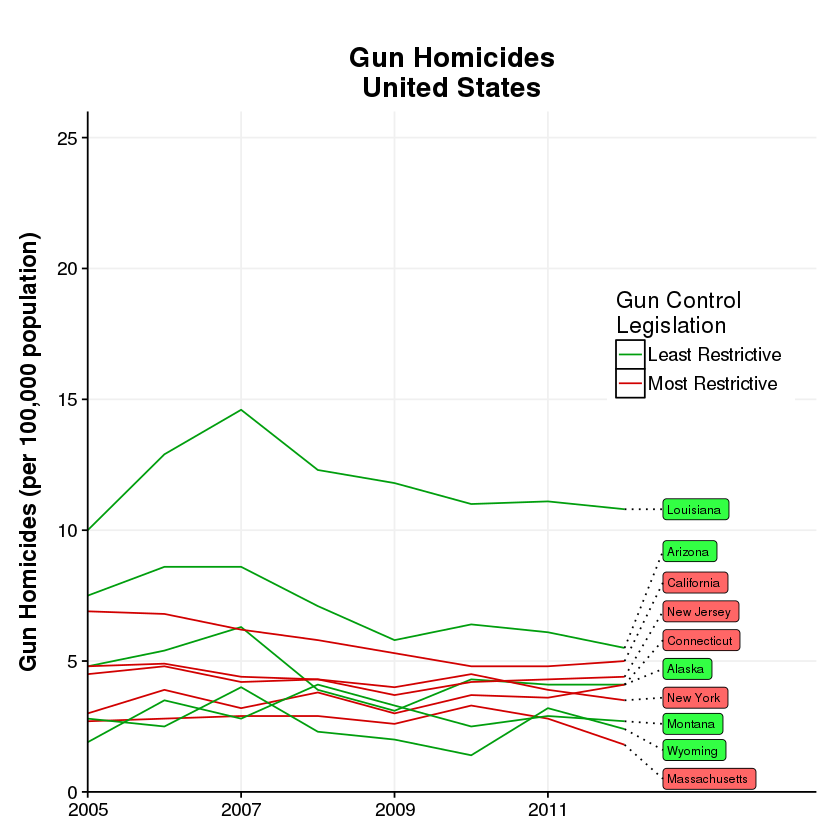

In [10]:
v2.homicides_by_state <- v2.data %>% 
    filter( State %in% select.states ) %>%
    filter( Year >= 2005 ) %>%
    ggplot(aes(x = Year, y = MurdersPer100000, color = brady, group = State)) +
    geom_line() +
    geom_label(data = v2.labels, 
               aes(x = label.align, y = murder.label.y, label = State, fill = brady), 
               color = "black", size = 2.5, hjust = 0) +
    geom_segment(aes(x = 2012, y = MurdersPer100000, xend = label.align, yend = murder.label.y), 
                 color = "black", linetype = 3, data = v2.labels) +
    scale_y_continuous(limits = c(0, 26), expand = c(0, 0)) +
    scale_x_continuous(limits = c(2005, 2014.5), breaks = seq(2005, 2011, 2), expand = c(0, 0)) +
    scale_color_manual(values = c(brady.green, brady.red)) +
    scale_fill_manual(values = c(brady.green.l, brady.red.l)) +
    ggtitle("Gun Homicides\nUnited States") +
    labs(y = "Gun Homicides (per 100,000 population)") +
    guides(color = guide_legend(title = "Gun Control\nLegislation"),
           fill = FALSE) +
    theme_Publication() +
    theme(
        #axis.title = element_blank(), axis.text = element_blank(), legend.title = element_blank(), legend.text = element_blank(),
        
        legend.title = element_text(hjust = 0.5),
        legend.justification = c(1, 1), 
        legend.position = c(0.97, 0.75),
        
        panel.grid.minor = element_blank(),
        axis.title.x = element_blank()
    )
v2.homicides_by_state
#ggsave(file = 'figures/2.homicides_by_state.tiff', v2.homicides_by_state, width = 5, height = 6, dpi = 300)

In [11]:
# Data Loading and Prep for Viz 3

# Load guns counts for each state
# http://concealednation.org/wp-content/uploads/2016/01/gun-table.png
gun_count <- read.csv("data/guns_per_state.csv", stringsAsFactors = F)

# Load gun ownership rates per state
# http://demographicdata.org/facts-and-figures/gun-ownership-statistics/
# downloaded as "DS_Final/004-Crime and Gun Statistics.xlsx"
gun_ownership <- read.csv("data/gun_ownership_state.csv", stringsAsFactors = F)
gun_prevalence <- merge(gun_count, gun_ownership) %>%
    rename(Ownership.Rate = Gun.Ownership)

# Merge data into state map data
data("fifty_states")
prevalence.data <- gun_prevalence %>%
    mutate(id = tolower(State),
           Gun.Owners.Per.1k = Ownership.Rate * 1000, 
           Registered.Guns.Per.1k = Guns.Per.1k)

gun.map <- prevalence.data %>%
    mutate(region = tolower(State)) %>%
    merge(fifty_states) %>%
    group_by(group) %>%
    arrange(order)

# Calculate centers to plot dots
data(state)
state.center <- data.frame ("State" = state.name, "Lon" = state.center$x, "Lat" = state.center$y)
state.center[state.center$State == "Alaska", "Lon"] <- -117.5 
state.center[state.center$State == "Alaska", "Lat"] <- 28.0744 

In [12]:
# Shared ggmap used by both plots
base.ggmap <- ggplot() + 
    coord_map("albers", lat0 = 30, lat1 = 40) + 
    theme_void() +
    theme(
        legend.box = "horizontal"
    )

Warning message:
"Ignoring unknown aesthetics: x, y"

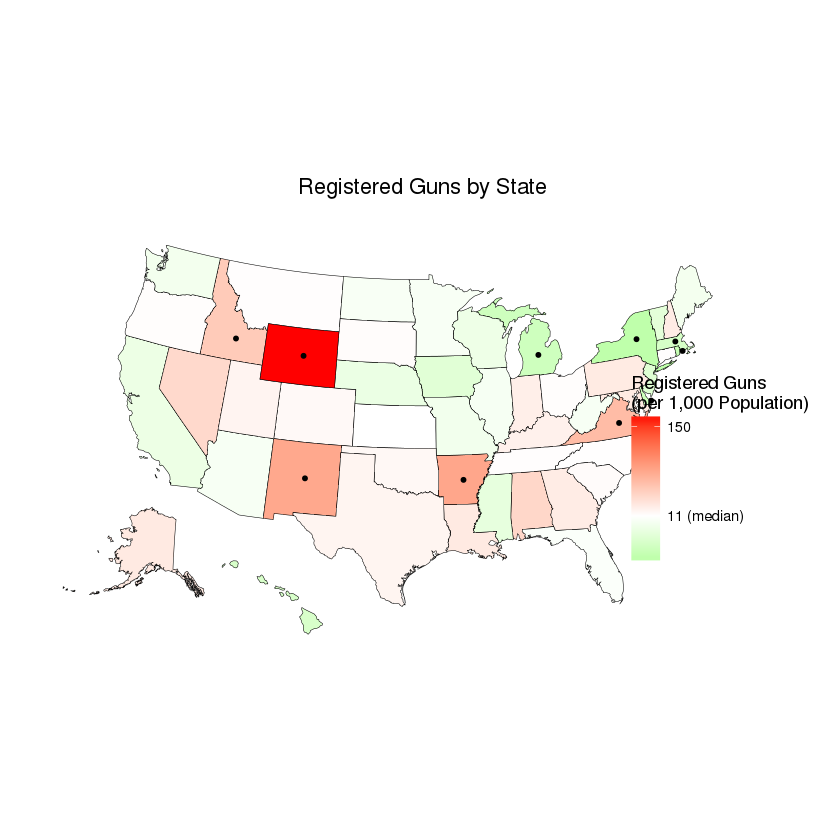

In [13]:
# Viz 3 part 1: Registered Guns
registered.points <- c(
    prevalence.data %>% arrange(Registered.Guns.Per.1k) %>% select(State, Registered.Guns.Per.1k) %>% head(5) %>% .$State,
    prevalence.data %>% arrange(Registered.Guns.Per.1k) %>% select(State, Registered.Guns.Per.1k) %>% tail(5) %>% .$State
    )

registered.map <- base.ggmap + 
    geom_map(data=gun.map, map=gun.map, color="black", size=0.15,
             aes(long, lat, map_id=region, fill=Registered.Guns.Per.1k)) + 
    geom_point(data=subset(state.center, State %in% registered.points), aes(Lon, Lat), size=1) +
    scale_fill_gradient2("Registered Guns\n(per 1,000 Population)", low = "green", mid = "white", high = "red", 
                         midpoint = log(11), trans = "log", breaks=c(11,150), labels=c("11 (median)", "150")) +
    ggtitle("Registered Guns by State") +
    theme(
        #text = element_blank(),
        plot.title = element_text(hjust = 0.5),
        legend.justification = c(1, 1), 
        legend.position = c(0.975, 0.65), 
        legend.key = element_blank()
    )
registered.map
#ggsave(file='figures/3.registered.map.tiff', registered.map, width = 9, height = 6, dpi=300)

Warning message:
"Ignoring unknown aesthetics: x, y"

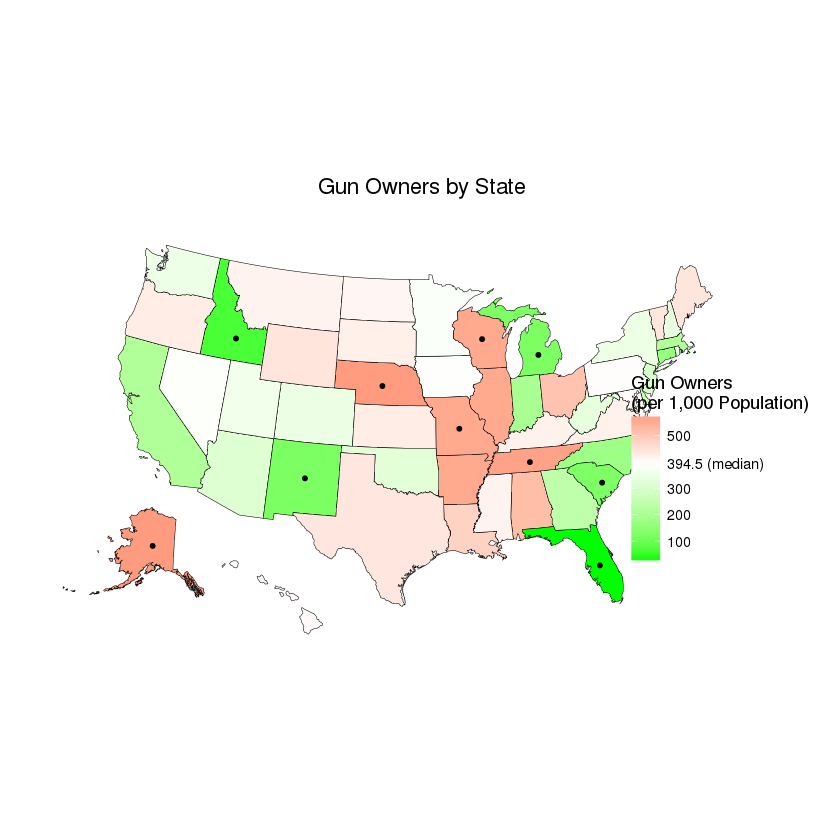

In [14]:
# Viz 3 part 2: Ownership Map
ownership.points <- c(
    prevalence.data %>% arrange(Gun.Owners.Per.1k) %>% select(State, Gun.Owners.Per.1k) %>% head(5) %>% .$State,
    prevalence.data %>% arrange(Gun.Owners.Per.1k) %>% select(State, Gun.Owners.Per.1k) %>% tail(5) %>% .$State
    )

ownership.map <- base.ggmap + 
    geom_map(data=gun.map, map=gun.map, aes(long, lat, map_id=region, fill=Gun.Owners.Per.1k), color="black", size=0.15) + 
    geom_point(data=subset(state.center, State %in% ownership.points), aes(Lon, Lat), size=1) +
    scale_fill_gradient2("Gun Owners\n(per 1,000 Population)", low = "green", mid = "white", high = "red", 
                         midpoint = 394.5, breaks=c(100,200,300,394.5,500), 
                         labels=c("100", "200", "300", "394.5 (median)", "500")) +
    ggtitle("Gun Owners by State") +
    theme(
        #text = element_blank(),
        plot.title = element_text(hjust = 0.5),
        legend.justification = c(1, 1), 
        legend.position = c(0.975, 0.65),
        legend.key = element_blank()
    )
ownership.map
#ggsave(file='figures/3.ownership.map.tiff', ownership.map, width = 9, height = 6, dpi=300)

In [16]:
# Calculate the top/bottom 5 to label the maps
print("Fewest Registered Guns")
prevalence.data %>%
    arrange(Registered.Guns.Per.1k) %>%
    select(State, Registered.Guns.Per.1k) %>%
    head(5)
print("Most Registered Guns")
prevalence.data %>%
    arrange(Registered.Guns.Per.1k) %>%
    select(State, Registered.Guns.Per.1k) %>%
    tail(5)
print("Lowest Gun Ownership")
prevalence.data %>%
    arrange(Gun.Owners.Per.1k) %>%
    select(State, Gun.Owners.Per.1k) %>%
    head(5)
print("Highest Gun Ownership")
prevalence.data %>%
    arrange(Gun.Owners.Per.1k) %>%
    select(State, Gun.Owners.Per.1k) %>%
    tail(5)

[1] "Fewest Registered Guns"


State,Registered.Guns.Per.1k
New York,3.3
Rhode Island,3.8
Delaware,4.2
Michigan,4.3
Massachusetts,4.9


[1] "Most Registered Guns"


,State,Registered.Guns.Per.1k
46,Idaho,24.2
47,Virginia,30.1
48,New Mexico,40.5
49,Arkansas,41.6
50,Wyoming,195.7


[1] "Lowest Gun Ownership"


State,Gun.Owners.Per.1k
Florida,36
Idaho,67
New Mexico,123
Michigan,126
South Carolina,128


[1] "Highest Gun Ownership"


,State,Gun.Owners.Per.1k
46,Missouri,553
47,Wisconsin,554
48,Tennessee,566
49,Nebraska,577
50,Alaska,578
